# Create Ungauged Experiments Gauge Groups

This notebook creates splits of Caravan + GRDC gauges for running models and assessing skill on ungauged basins. 

The splits are:

  1) Random (K-Fold)

  2) Continents

  3) Climate Zones
  
  4) Countries

  5) Hydrologically-Separated Basins

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import geopandas as gpd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
from sklearn.model_selection import KFold

In [3]:
from backend import data_paths
from backend import gauge_groups_utils
from backend import loading_utils
from backend import evaluation_utils

# Experiment Setup

## Create Gauge Groups Directory

In [ ]:
DELETE_EXISTING_GAUGE_GROUPS = False

if os.path.exists(data_paths.GAUGE_GROUPS_DIR) and DELETE_EXISTING_GAUGE_GROUPS:
    raise ValueError('I am making you comment this error and rerun this cell if '
                     'you really want to delete the existing gauge groups.')
    shutil.rmtree(data_paths.GAUGE_GROUPS_DIR)
os.makedirs(data_paths.GAUGE_GROUPS_DIR)

## Load Gauge Groups

In [4]:
full_gauge_group = gauge_groups_utils.load_gauge_group(data_paths.FULL_GAUGE_GROUP_FILE)
print(f'There are {len(full_gauge_group)} gauges.')

There are 5678 gauges.


In [5]:
# The HydroBASINS info file assocaites each gauge with a HydroBASINS polygon.
# We will only keep one gauge per HyBAS level 12 polygon.
with open(data_paths.HYBAS_INFO_FILE, 'r') as f:
    gauges_with_hybas_home_polygon = pd.read_csv(f, index_col='unique_gauge_id')
gauge_to_hybas_id = gauges_with_hybas_home_polygon[['HYBAS_ID']]
print(f'There are {len(set(full_gauge_group) - set(gauge_to_hybas_id.index))} basins missing from the hybas info file.')

gauge_to_hybas_id = gauge_to_hybas_id.loc[full_gauge_group]
gauge_to_hybas_id = gauge_to_hybas_id.loc[gauge_to_hybas_id.drop_duplicates(subset=['HYBAS_ID']).index]
full_gauge_group = list(gauge_to_hybas_id.index)

There are 0 basins missing from the hybas info file.


/tmp/ipykernel_270088/2591505088.py:4: DtypeWarning: Columns (18,20,21,22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  gauges_with_hybas_home_polygon = pd.read_csv(f, index_col='unique_gauge_id')


# Create Random Split Gauge Groups

In [11]:
KFOLD_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'kfold_splits' 
os.makedirs(KFOLD_GAUGE_GROUPS_DIR)

FileExistsError: [Errno 17] File exists: '/home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/kfold_splits'

In [13]:
kf = KFold(n_splits=10, random_state=None, shuffle=True)

for split_idx, (_, test_index) in enumerate(kf.split(full_gauge_group)):
  
    # Create the gauge list for this split.
    split_basins = [full_gauge_group[basin_idx] for basin_idx in test_index]

    # Save the list to a file.
    filename = KFOLD_GAUGE_GROUPS_DIR / f'random_group_{split_idx}.txt'
    gauge_groups_utils.write_gauge_group(filename=filename, basins=split_basins)
    print(f'Saved {len(split_basins)} basins from a random split to ::: {filename}.')

Saved 568 basins from a random split to ::: /home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/kfold_splits/random_group_0.txt.
Saved 568 basins from a random split to ::: /home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/kfold_splits/random_group_1.txt.
Saved 568 basins from a random split to ::: /home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/kfold_splits/random_group_2.txt.
Saved 568 basins from a random split to ::: /home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/kfold_splits/random_group_3.txt.
Saved 568 basins from a random split to ::: /home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/kfold_splits/random_group_4.txt.
Saved 568 basins from a random split to ::: /home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/kfold_splits/random_group_5.txt.
Saved 568 basins from a random split to ::: /home/gs

# Create Continent Gague Groups

In [14]:
CONTINENT_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'continent_splits' 
os.makedirs(CONTINENT_GAUGE_GROUPS_DIR)

FileExistsError: [Errno 17] File exists: '/home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/continent_splits'

## Map Caravan and GRDC to Continent

In [15]:
# Mapping from Caravan source dataset to continent.
# This is only needed if the full gauge group includes Caravan gauges.
caravan_continent_mapping = {
    'CAMELS': 'North America',
    'CAMELSAUS': 'South West Pacific',
    'CAMELSBR': 'South America',
    'CAMELSCL': 'South America',
    'CAMELSDK': 'Europe',
    'CAMELSGB': 'Europe',
    'LAMAH': 'Europe',
    'HYSETS': 'North America'
}

def get_caravan_continent(basin):
    source = basin.split('_')[1]
    for source in caravan_continent_mapping:
        if f'_{source}_' in basin:
            return caravan_continent_mapping[source]

gauge_continents_caravan = {basin: get_caravan_continent(basin) for basin in full_gauge_group if 'CARAVAN' in basin} 

In [16]:
# Maps GRDC gauges to continents.
with open(data_paths.GRDC_METADATA_FILE, 'rt') as f:
    grdc_metadata = pd.read_csv(f, index_col='grdc_no')

wmo_region_mapping = {
    1: 'Africa',
    2: 'Asia',
    3: 'South America',
    4: 'North America',
    5: 'South West Pacific',
    6: 'Europe',
}

def get_grdc_continent(basin):
    basin_id = int(basin.split('_')[-1])
    wmo_region = grdc_metadata.loc[basin_id, 'wmo_reg']
    return wmo_region_mapping[wmo_region]

gauge_continents_grdc = {basin: get_grdc_continent(basin) for basin in full_gauge_group if 'GRDC' in basin} 

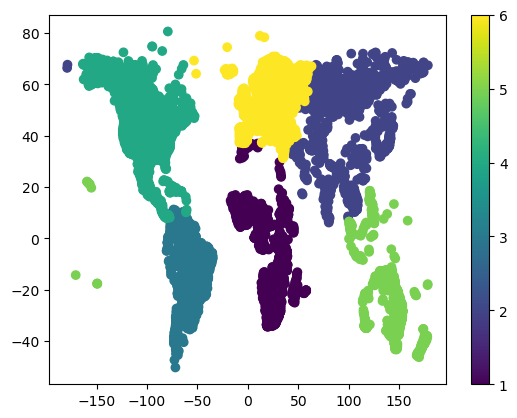

In [17]:
# Visual check that the WMO regions are correct.
plt.scatter(grdc_metadata['long'], grdc_metadata['lat'], c=grdc_metadata['wmo_reg'])
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")

## Save Continent Gauge Groups

In [ ]:
def save_continent_file(continent, basins):
    continent_for_filename = continent.lower().replace(' ', '_')
    filename = CONTINENT_GAUGE_GROUPS_DIR / f'{continent_for_filename}.txt'
    gauge_groups_utils.write_gauge_group(filename=filename, basins=basins)
    return filename

In [ ]:
gauge_continents = {**gauge_continents_grdc, **gauge_continents_caravan}
print(f'There are {len(gauge_continents)} gauges.')

for continent in wmo_region_mapping.values():
    basins_in_continent = [basin for basin, cont in gauge_continents.items() if cont == continent]
    filename = save_continent_file(continent, basins_in_continent)
    print(f'Saved {len(basins_in_continent)} basins in {continent} to ::: {filename}')

# Create Climate Zone Gauge Groups

## Separate into Climate Zones

In [18]:
# We will get the climate zones from HyBAS attributes.
# First, we need the hybas polygon for each gauge.
gauges_with_hybas_home_polygon = loading_utils.load_hydroatlas_info_file()
gauges_with_hybas_home_polygon = gauges_with_hybas_home_polygon[['longitude',	'latitude', 'unique_gauge_id']]

# Get climate zone from the HyBAS attributes file.
hybas_climate_zones = loading_utils.load_hydroatlas_attributes_file()

# Extract climate zones for gauge group into a df.
climate_zones_df = pd.concat([hybas_climate_zones.loc[gauges_with_hybas_home_polygon.index], gauges_with_hybas_home_polygon], axis=1)
climate_zones_df.reset_index(inplace=True)
climate_zones_df.set_index('unique_gauge_id', inplace=True)
climate_zones_df = climate_zones_df.loc[full_gauge_group]

/home/gsnearing/github_repo/global_streamflow_model_paper/notebooks/backend/loading_utils.py:52: DtypeWarning: Columns (18,20,21,22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f, index_col='HYBAS_ID')


In [19]:
# Mapping from integer values in the attributes df to named climate zones.
climate_zone_mapping = {
    1: 'Arctic 1',
    2: 'Arctic 2',
    3: 'Extremely Cold and Wet 1',
    4: 'Extremely Cold and Wet 2',
    5: 'Cold and Wet',
    6: 'Extremely Cold and Mesic',
    7: 'Cold and Mesic',
    8: 'Cool Temperate and Dry',
    9: 'Cool Temperate and Xeric',
    10: 'Cool Temperate and Moist',
    11: 'Warm Temperate and Mesic',
    12: 'Warm Temperate and Xeric',
    13: 'Hot and Mesic',
    14: 'Hot and Dry',
    15: 'Hot and Arid',
    16: 'Extremely Hot and Arid',
    17: 'Extremely Hot and Xeric',
    18: 'Extremely Hot and Moist'
}

# All climate zones.
climate_zones = set(climate_zones_df['clz_cl_smj'])

# Separate basins into all climate zones
basins_in_climate_zone = {}
for zone in climate_zones:
    basins_in_climate_zone[climate_zone_mapping[zone]] = [
        basin for basin, data in climate_zones_df.iterrows() if data['clz_cl_smj'] == zone]

# Turn the zones into descriptive names.
climate_zones = set([climate_zone_mapping[zone] for zone in climate_zones_df['clz_cl_smj']])

In [20]:
# Combine certain climate zones without a lot of basins: Cold and Wet.
basins_in_climate_zone['Cold and Wet'] = basins_in_climate_zone['Cold and Wet'] + \
                                         basins_in_climate_zone['Extremely Cold and Wet 1'] + \
                                         basins_in_climate_zone['Extremely Cold and Wet 2']
basins_in_climate_zone.pop('Extremely Cold and Wet 1')
basins_in_climate_zone.pop('Extremely Cold and Wet 2')

# Combine certain climate zones without a lot of basins: Cold and Mesic.
basins_in_climate_zone['Cold and Mesic'] = basins_in_climate_zone['Extremely Cold and Mesic'] + \
                                           basins_in_climate_zone['Cold and Mesic'] + \
                                           basins_in_climate_zone['Arctic 2']
basins_in_climate_zone.pop('Extremely Cold and Mesic')
basins_in_climate_zone.pop('Arctic 2')

# Revised list of climate zones.
climate_zones = list(basins_in_climate_zone.keys())
print(f'There are {len(climate_zones)} climate zones.')

There are 13 climate zones.


## Save Climate Gauge Groups

In [ ]:
CLIMATE_ZONES_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'climate_splits' 
os.makedirs(CLIMATE_ZONES_GAUGE_GROUPS_DIR)

def save_climate_file(zone, basins):
    zone_name = zone.lower().replace(' ', '_')
    filename = CLIMATE_ZONES_GAUGE_GROUPS_DIR / f'{zone_name}.txt'
    gauge_groups_utils.write_gauge_group(filename=filename, basins=basins)
    return filename

In [ ]:
for zone in climate_zones:
    filename = save_climate_file(zone, basins_in_climate_zone[zone])
    print(f'Saved {len(basins_in_climate_zone[zone])} basins in zone {zone} to ::: {filename}')

# Create Country Gauge Groups

## Separate into Countries

In [22]:
hydroatlas_countries = loading_utils.load_hydroatlas_country_file()
gauges_with_countries = list(set(gauge_to_hybas_id['HYBAS_ID']).intersection(set(hydroatlas_countries.index)))
gauge_countries = hydroatlas_countries.loc[gauges_with_countries]
gauge_countries = gauge_countries[~gauge_countries.index.duplicated(keep='first')]
gauge_countries = pd.concat([gauge_to_hybas_id.reset_index().set_index('HYBAS_ID'), gauge_countries], axis=1)
gauge_countries.reset_index(inplace=True)
gauge_countries.set_index('unique_gauge_id', inplace=True)
gauge_countries = gauge_countries.drop('index', axis=1)
gauge_countries = gauge_countries.dropna()

## Save Country Gauge Groups

In [21]:
def save_country_file(country, basins):
    country_string = country.lower()
    country_string = country_string.replace(' ', '_')
    country_string = country_string.replace('\'', '')
    country_string = country_string.replace('ã', 'a')
    country_string = country_string.replace('é', 'e')
    country_string = country_string.replace('í', 'i')
    country_string = country_string.replace('ô', 'o')
    filename = COUNTRIES_GAUGE_GROUPS_DIR / f'{country_string}.txt'
    gauge_groups_utils.write_gauge_group(filename=filename, basins=basins)
    return filename

FileExistsError: [Errno 17] File exists: '/home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/country_splits'

In [ ]:
COUNTRIES_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'country_splits' 
os.makedirs(COUNTRIES_GAUGE_GROUPS_DIR)

In [ ]:
countries = set(gauge_countries['Country'])
for country in countries:
    basins_in_country = [basin for basin, data in gauge_countries.iterrows() if data['Country'] == country]
    print(country, len(basins_in_country))
    filename = save_country_file(country=country, basins=basins_in_country)

# Hydrologically Separated Basins

## Helper Functions

In [23]:
def split_in_two(x: list[int]):

    x = random.sample(x, len(x))
    maxx = x.pop(x.index(max(x)))
    x.append(maxx)

    idx = len(x) // 2
    diff = abs(sum(x[:idx]) - sum(x[idx:]))
    while abs(sum(x[:idx+1]) - sum(x[idx+1:])) < diff:
        idx += 1
        if idx == len(x):
            break
        diff = abs(sum(x[:idx]) - sum(x[idx:]))
    while abs(sum(x[:idx-1]) - sum(x[idx-1:])) < diff:
        idx -= 1
        if idx == 0:
            break
        diff = abs(sum(x[:idx]) - sum(x[idx:]))
    return x[:idx], x[idx:]


def split_in_2n(
    x: list[int],
    n: int,
    count: int = 1
) -> tuple[list[list[int]], int]:

    if np.log2(n) != int(np.log2(n)):
        raise ValueError('Number of groups must be a power of 2.')
    if count == 0 and len(x) < n:
        raise ValueError('Number of groups is larger than number of elements in the list.')

    if not isinstance(x[0], list):
        x = split_in_two(x)

    if count != np.log2(n):
        return list(itertools.chain.from_iterable([split_in_2n(xi, n, count+1) for xi in x]))
    else:
        return x

## Separate

In [40]:
# Load file with HyBAS metadata for all gauges.
metadata = loading_utils.load_hydroatlas_info_file()

# Pull gauges from the gauge group.
metadata.set_index('unique_gauge_id', inplace=True)
metadata = metadata.loc[[idx for idx in metadata.index if idx in full_gauge_group]];
print(f'There are {metadata.shape[0]} gauges in the metadata file.');

/home/gsnearing/github_repo/global_streamflow_model_paper/notebooks/backend/loading_utils.py:52: DtypeWarning: Columns (18,20,21,22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f, index_col='HYBAS_ID')


There are 5678 gauges in the metadata file.


In [43]:
# Number of gauges in each terminal basin.
terminal_basins = list(metadata['MAIN_BAS'].unique())
gauge_counts = metadata['MAIN_BAS'].value_counts()
print(f'There are {len(terminal_basins)} terminal basins.')

There are 1294 terminal basins.


In [44]:
# Create a pure counter of the terminal basin.
for terminal_basin_idx, terminal_basin in enumerate(terminal_basins):
    metadata.loc[metadata['MAIN_BAS'] == terminal_basin, 'terminal_basin_idx'] = terminal_basin_idx

In [45]:
# Number of gauge groups -- must be a power of 2.
num_gauge_groups = 2**3

In [50]:
# Create matched lists of the terminal HyBAS IDs and the gauges counts for each one.
all_counts_list = [] #list(gauge_counts.values)
all_hybas_ids_list = []#list(gauge_counts.keys())
for hid, count in gauge_counts.items():
    all_counts_list.append(count)
    all_hybas_ids_list.append(hid)

# Terminal HyBAS IDs are ordered by number of gauges that drain to each one.
# Reordering these randomly reduces bias in the splitting algorithm.
random_idx = list(range(len(gauge_counts)))
random.shuffle(random_idx)
all_counts_list = [all_counts_list[i] for i in random_idx]
all_hybas_ids_list = [all_hybas_ids_list[i] for i in random_idx]

# Split the gauge groups.
counts_split = split_in_2n(all_counts_list, num_gauge_groups)
counts_in_groups = [sum(split) for split in counts_split]
print(f'There are {len(counts_split)} splits with '
      f'{counts_in_groups} gauges in each split '
      f'({sum(counts_in_groups)} total).')
print('-----------------------------------------------')

# Storage for which HyBAS ID and which gauges go into which split.
split_hybas_id_mapper = {split_idx: [] for split_idx in range(num_gauge_groups)}
gauges_in_split = {split_idx: [] for split_idx in split_hybas_id_mapper.keys()}

# Loop through the splits to find HyBAS IDs and associated gauges for each split.
for split_idx, split in enumerate(counts_split):

    # Match HyBAS IDs to the splits.
    for gauge_count in split:
        idx = all_counts_list.index(gauge_count)
        split_hybas_id_mapper[split_idx].append(all_hybas_ids_list[idx])
        all_counts_list.pop(idx)
        all_hybas_ids_list.pop(idx)

    # Match gauges with terminating HyBAS IDs.
    hybas_list = split_hybas_id_mapper[split_idx]
    list_of_lists = [metadata[metadata['MAIN_BAS'] == hybas_id].index for hybas_id in hybas_list]
    gauges_in_split[split_idx] = list(itertools.chain.from_iterable(list_of_lists))

    # Store the split ID in the metadata dataframe.
    metadata.loc[gauges_in_split[split_idx], 'split'] = split_idx

    # Report to screen.
    print(
        f'Split index: {split_idx}, ',
        f'# HyBAS terminal IDs: {len(hybas_list)}, ',
        f'# Gauges: {len(gauges_in_split[split_idx])}',
    )

There are 8 splits with [710, 709, 711, 709, 676, 739, 669, 755] gauges in each split (5678 total).
-----------------------------------------------
Split index: 0,  # HyBAS terminal IDs: 213,  # Gauges: 710
Split index: 1,  # HyBAS terminal IDs: 248,  # Gauges: 709
Split index: 2,  # HyBAS terminal IDs: 176,  # Gauges: 711
Split index: 3,  # HyBAS terminal IDs: 179,  # Gauges: 709
Split index: 4,  # HyBAS terminal IDs: 170,  # Gauges: 676
Split index: 5,  # HyBAS terminal IDs: 92,  # Gauges: 739
Split index: 6,  # HyBAS terminal IDs: 166,  # Gauges: 669
Split index: 7,  # HyBAS terminal IDs: 50,  # Gauges: 755


Text(0, 0.5, 'Gauge Count')

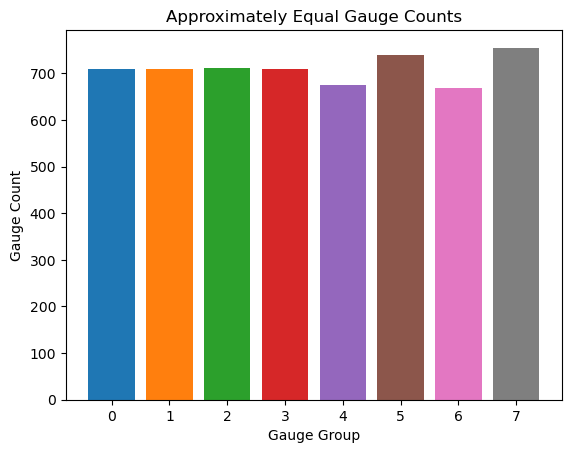

In [52]:
plt.bar(
    range(len(gauges_in_split)),
    [len(g) for g in gauges_in_split.values()],
    color=evaluation_utils.COLORS
);
plt.xticks(ticks=range(len(gauges_in_split)), labels=[int(g) for g in gauges_in_split.keys()])
plt.title('Approximately Equal Gauge Counts')
plt.xlabel('Gauge Group')
plt.ylabel('Gauge Count')

## Save Gauge Groups

In [54]:
HYDROLOGICALLY_SEPARATED_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'hydrologically_separated' 
os.makedirs(HYDROLOGICALLY_SEPARATED_GAUGE_GROUPS_DIR)

FileExistsError: [Errno 17] File exists: '/home/gsnearing/github_repo/global_streamflow_model_paper/gauge_groups/dual_lstm/hydrologically_separated'

In [55]:
for split_idx, gauges in gauges_in_split.items():
    filename = HYDROLOGICALLY_SEPARATED_GAUGE_GROUPS_DIR / f'split_{split_idx}.txt'
    gauge_groups_utils.write_gauge_group(filename=filename, basins=gauges)